# Testing a new method: Planetesimal accretion until Classical isolation mass value

In [1]:
import numpy as np
from astropy import constants as c
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"
import math as mth
import pandas as pd
from PP import pebble_predictor
import OL18_new
#from allplanets import all_planets

In [2]:
# some useful constants in cgs
year = 365.25*24*3600   #in seconds
au = c.au.cgs.value
MS = c.M_sun.cgs.value      #mass of the sun in cgs
ME = c.M_earth.cgs.value    #mass of the earth in cgs
k_b = c.k_B.cgs.value       #boltzmann const
m_p = c.m_p.cgs.value       #mass of proton
Grav = c.G.cgs.value        #gravitational const
au = c.au.cgs.value     

ZS=0.012                    #metallicity of the sun
RS=c.R_sun.cgs.value                #Radius of sun in cm
RE=c.R_earth.cgs.value

Nr = 1000 # number of grid points      
rhop = 1.25 # internal density of dust grains 
Rout = 1000.*au

epsilon=[]
iso=0.
    

In [3]:
#SAMPLE PLANETARY PARAMETERS: JUPITER
#Qatar-1 b	2010	0.02332	0.0004	-0.0004	12.812	0.291	-0.28	411.27202	16.52716	-15.57367	1.076	0.057	-0.053	0.8	0.02	-0.02	0.84	0.04	-0.04	0.171	0.097	-0.094	2017-02

Z = -0.17

M_star = 0.41*MS

R_star = 0.41*RS

location = 0.01*au

alpha = 10**(-5)

vfrag = 400

#print(1.5*R_star/au)

In [4]:
Z0 = (10**Z)*ZS    #solids-to-gas ratio 
mdisk=0.1*M_star            #assuming that disk mass is 10% of the star mass
Rc=30*au 

Rin = 1.5*R_star        #inner radius of disk is 1au and outer radius is 1000 a (HUH)
rgrid = np.logspace(np.log10(Rin),np.log10(Rout),Nr)   
SigmaGas = mdisk / (2.*np.pi*Rc**2.) * (rgrid/Rc)**(-1.) * np.exp(-1.*(rgrid/Rc)) # gas surface density
SigmaDust = Z0*SigmaGas # dust surface density
T = 280 * ((au*M_star)/(rgrid*MS))**(0.5) # temperature profile
cs = np.sqrt(k_b*T/(2.3*m_p))      #sound speed
OmegaK = np.sqrt(Grav*M_star/rgrid**3.) # Keplerian frequency       #using Mstar to be MS here by default
ir = rgrid.searchsorted(location)
#print(rgrid/au)
print(ir)

98


In [5]:
Nt = 1000   # how many points on the time grid?
endtime = 3.e6*year
timegrid = np.logspace(np.log10(year/100),np.log10(endtime),Nt)     #starts from 1 year and ends at endtime defined above, goes for Nt number of points

#finding stokes number and flux numbers
stokes,flux_values=pebble_predictor(rgrid=rgrid,tgrid=timegrid,Mstar=M_star,SigmaGas=SigmaGas,T=T,SigmaDust=SigmaDust,alpha=alpha,vfrag=vfrag,rhop=rhop)

H_g = cs/OmegaK # gas scale height
rhog = SigmaGas / (np.sqrt(2.*np.pi)*H_g) # gas midplane density
pressure = rhog * (cs**2.) # gas midplane pressure

dpdr = (pressure[ir+1]-pressure[ir-1])/(rgrid[ir+1]-rgrid[ir-1])
eta = dpdr / (2.*rhog[ir]*(OmegaK[ir]**2.)*rgrid[ir])

print("value of dpdr: ", dpdr)
print("value of eta: ", eta)

value of dpdr:  -4.575487530174661e-05
value of eta:  -0.0002433694224827033


/Users/jayashreenarayan/Documents/GitHub/Summer-2023---Pebble-Predictor-Analyses/PP.py:78: RuntimeWarning: overflow encountered in exp
  stini = st0*np.exp(tgrid[it]/tgrowth[:])


# Planetesimal accretion until Classical isolation mass

In [6]:
Classical_iso = 0.1*ME* ((SigmaDust[ir]/5)**(3/2)) * (rgrid[ir]/au)**3 * ((M_star/MS)**(-1/2))
print("Classical isolation mass value: ", Classical_iso)
print("0.001ME: ", 0.001*ME)

print(Classical_iso / (0.001*ME))

Classical isolation mass value:  5.180039561175737e+24
0.001ME:  5.972167867791379e+24
0.8673633554596337


# Time taken to reach this Classical Isolation mass?

## 2-fold process: 
- Step 1 (T1): Initial mass $(10^{-6})$ g to Transition mass (M_t)
- Step 2 (T2): Transition mass (M_t) to Classical isolation mass (Classical_iso)
- Step 3: Once classical isolation mass is reached, the planet grows by pebble accretion

# Step 1: Calculating T1

In [7]:
M0 = 10**(-6)*ME # initial mass of planetesimal in g
R0 = ((3*M0)/(4*mth.pi*3))**(1/3) # initial radius of planetesimal in cm

# Transition radius
R_t = (580 * ((R0/(10**6))**(3/7)) * ((rgrid[ir]/(4*au))**(5/7)) * ((SigmaDust[ir]/3)**(2/7)) * (1000*100)) # in cm
print("Transition Radius in cm: ", R_t)
# Transition Mass
M_t = 3 * ((4/3) * mth.pi * (R_t)**3) # in g
print("Transition mass: ", M_t)

# Time taken for this:
N = mth.log2((abs(M_t)/ M0))
tau_rg = (0.1 * 3 * R0)/(OmegaK[ir] * SigmaDust[ir])

T1 = N*tau_rg
print(T1/year)
it2 = timegrid.searchsorted(abs(T1)) # position at which T1 exists
totmass=[]
for i in range(0,it2+1):
    totmass.append(M_t/ME)

print(totmass)

Transition Radius in cm:  11585095.791451389
Transition mass:  1.953928876965648e+22
0.6355909410550931
[3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.2717246403997144e-06, 3.27172

# Step 2: Calculating T2

### T2 is from Transition mass to classical isolation mass

In [8]:
for i in range(it2, 1000):
    
    m = totmass[-1]*ME          #At the first iteration this is the value of the transition mass, after that it increases with time
    r = ((3*m)/(4*mth.pi*3))**(1/3)     #
    dt=(timegrid[i]-timegrid[i-1])
    dm= mth.pi * OmegaK[ir] * SigmaDust[ir] * r**2 * dt
    totmass.append(((totmass[-1]*ME)+dm)/ME)

    if totmass[-1] >= Classical_iso/ME:
        totmass[-1]
        totmass.append(Classical_iso/ME)
        break

#print(Classical_iso/ME)
#print(len(totmass))
k = len(totmass)
#print(totmass)
#print(totmass[-1])

### Calculating T2:
- We have obtained $M$ = $\pi \Omega_k \Sigma_{plts} R_p^2 \Delta T$
- So then we just need $\Delta T$ = $M$ / ($\pi \Omega_k \Sigma_{plts} R_p^2$ )
- This will be the change in time taken -- giving us the position of T2 on the timegrid.


In [9]:
R_p = r = ((3*(totmass[-1]*ME))/(4*mth.pi*3))**(1/3)
delT = (totmass[-1]*ME)/(mth.pi * OmegaK[ir] * SigmaDust[ir] * R_p**2 )
#print(delT/year)
T2 = T1 + delT
print("Value of T1 in years: ", T1/year)
print("Value of delT; ", delT/year)
print("Value of T2 + T1 + delT: ", T2/year)
it3 = timegrid.searchsorted(T2)
print("Position of T2 in timegrid: ", it3)

Value of T1 in years:  0.6355909410550931
Value of delT;  47.261515639561225
Value of T2 + T1 + delT:  47.89710658061631
Position of T2 in timegrid:  434


In [10]:
for i in range(k,1000):
    totmass.append(0)
print(len(totmass))
totmass_arr = np.asarray(totmass)
totmass[-2]

1000


0

0.30921230704490693 :M_iso value in ME units


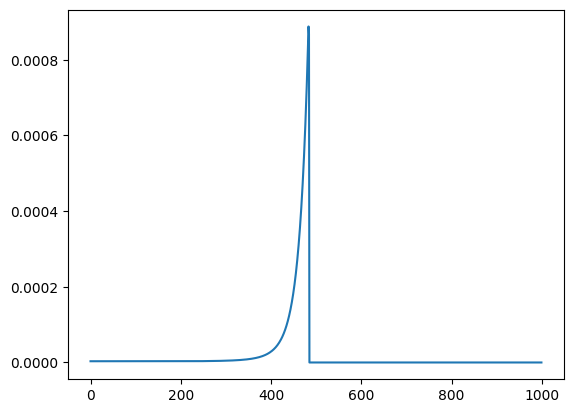

In [11]:
M_iso=40*ME*(M_star/MS)*((H_g[ir]/(0.05*location))**3)
print(M_iso/ME, ":M_iso value in ME units")
hgas=H_g[ir]/rgrid[ir]
#print(totmass_arr)

plt.plot(totmass_arr)

In [12]:
#Seeing values of totmass
print("Initial embryo mass before pebble accretion (in units of earth masses) ",totmass[it3])
print("Pebble accretion begings at:",it3,"th position of the time grid which is at",T2/year,"years")


Initial embryo mass before pebble accretion (in units of earth masses)  9.672453045354074e-05
Pebble accretion begings at: 434 th position of the time grid which is at 47.89710658061631 years


## After reaching Classical Isolation mass:

### Once the planet reaches its classical isolation mass, it starts growing by pebble accretion.

In [13]:
for i in range(it3,1000):             #through the entire timegrid
    dt=(timegrid[i]-timegrid[i-1])                          #time difference
    R=((((3/(4*mth.pi))*totmass_arr[i-1]*ME/3)**(1/3)))/location       #radius of planet in terms of au; density of the planet as it grows is
    QP=totmass_arr[i-1]*ME/MS                                   #QP ratio
    eps=OL18_new.epsilon_general (tau=stokes[i,ir], qp=QP, eta=eta, hgas=hgas, alphaz=alpha, Rp=R)
    epsilon.append(eps)
    totmass_arr[i]=totmass_arr[i-1]+((flux_values[i,ir]*eps*dt)/ME)       #this becomes the array of mass as a function of time    
    #print(M_iso/ME)
    if totmass_arr[i]>=M_iso/ME:
        totmass_arr[i]=M_iso/ME
        #iso+=1
        #print(i)

#print(totmass_arr)
it = timegrid.searchsorted((3*(10**6)) * year)
print(it)

if totmass_arr[it]>=M_iso/ME:
    iso+=1

print("isolated? ",iso, "alpha =  ", alpha, "vfrag = ", vfrag)


999
isolated?  1.0 alpha =   1e-05 vfrag =  400


In [14]:
totmass_arr[-1]*ME

1.8466678044592352e+27

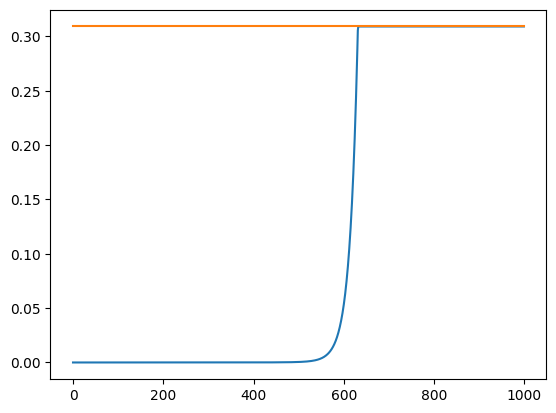

In [15]:
plt.plot(totmass_arr)
K=[]
for i in range(len(totmass_arr)):
    K.append(M_iso/ME)

plt.plot(K)